## Applying topological data analysis to corpus comparison

This is a demostration of some experiments given in my paper.

So, let's load some packages:

In [1]:
import re
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import dionysus as dn
import numpy as np
import pymorphy2
import nltk
from string import punctuation

### Prepare texts 

Then we create some usefull functions:

In [2]:
def tsne_plot(model):
    """Creates and TSNE model and plots it"""
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    perplexitys = [5, 30, 50, 100]
#     perplexitys = [0, 3]
    
    position = 221
    
    plt.figure(1, figsize=(10, 10)) 

    
    for i in range(len(perplexitys)):
        tsne_model = TSNE(perplexity=perplexitys[i], n_components=2, init='pca', n_iter=5000, random_state=23)
        new_values = tsne_model.fit_transform(tokens)

        x = []
        y = []
        for value in new_values:
            x.append(value[0])
            y.append(value[1])
            
        print(position)
        
        plt.subplot(position)
        plt.title('Perplexity = {}'.format(perplexitys[i]))
        
        for i in range(len(x)):
            plt.scatter(x[i],y[i])
#             plt.annotate(labels[i],
#                      xy=(x[i], y[i]),
#                      xytext=(5, 2),
#                      textcoords='offset points',
#                      ha='right',
#                      va='bottom')
        
        position += 1
        
    plt.show()

In [3]:
PATH = '/Users/alexey/Documents/GitHub/dialog_persistent/stop words/sw.txt'

with open(PATH) as f:
    stop_words = f.read().splitlines()

In [4]:
def check_sentence(sentence):
    '''Check for stop words'''
    for element in sentence:
        if element in stop_words:
            sentence.remove(element)
    
    return sentence

In [5]:
def tokenize_and_lemmatize(path, text=None):
    '''
    This function is used to tokenize and lemmatize texts.
    
    '''
    
    if text:
        file = text
    else:
        file = open(path).read()

    morph = pymorphy2.MorphAnalyzer()

    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

    sentences = tokenizer.tokenize(file)

    sentenses_splitted = []

    for s in sentences:   
        s = s.translate(str.maketrans('','', punctuation))
        sentenses_splitted.append(s.lower().split())

    for sentence in sentenses_splitted:
        for i in range(len(sentence)):
            p = morph.parse(sentence[i])[0]
            sentence[i] = p.normal_form
            
    for i in range(len(sentenses_splitted)):
        sentenses_splitted[i] = check_sentence(sentenses_splitted[i])
    

    return sentenses_splitted

Get vectors from word2vec models:

In [6]:
def get_vectors(model, dimensions=100): 
    '''
    This function is used to extract vectors
    '''
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])

    result_array = np.empty((0, dimensions))

    for token in tokens:
        result_array = np.append(result_array, [token], axis=0)
    
    return result_array

Transform coordinates (escape all negatives due to algoritm problems):

In [7]:
def transorm(array):
    '''
    Transalate data cloud to positive coordinates
    '''
    
    if array.min() < 0:
        new_array = array - array.min()
        return new_array
    else:
        raise ValueError('This array has no negative values')
    

## Then some experiments:

In [8]:
def analyze_text(path, min_count=10, transf=False, text_f=None):
    
    if text_f:
        text = tokenize_and_lemmatize(path=None, text=text_f)
    else:
        text = tokenize_and_lemmatize(path=path)
    model = word2vec.Word2Vec(text, size=100, window=20,
                                  min_count=min_count, workers=4)
    vectors = get_vectors(model)
    
    if transf is True:
        vectors = transorm(vectors)
        
    f_lower_star = dn.fill_freudenthal(vectors)
    p = dn.homology_persistence(f_lower_star)
    dgms = dn.init_diagrams(p, f_lower_star)
    
    return dgms, model, vectors
    

Here we apply our function to out text (Nabokov's Mashenka):

In [ ]:
text_1 = tokenize_and_lemmatize('/Users/alexey/Documents/GitHub/dialog_persistent/texts/mashenka.txt')

In [ ]:
text_1[1:3]

Then we create a model:

In [ ]:
model_1 = word2vec.Word2Vec(text_1, size=100, window=20,
                                  min_count=10, workers=4)

In [ ]:
# tsne_plot(model_1)

Here I obtain vectors from the model 1 -- with Nabokov's Mashenka:

In [ ]:
vectors_1 = get_vectors(model_1)

vectors_1 = transorm(vectors_1)

Then create a lower star filtration:

In [ ]:
f_lower_star = dn.fill_freudenthal(vectors_1)

In [ ]:
p = dn.homology_persistence(f_lower_star)
dgms1 = dn.init_diagrams(p, f_lower_star)

In [ ]:
# dn.plot.plot_bars(dgms1[0], show = True, order='death')

Then let's compare it with another Nabokov's book -- Drugie Berega (which is bigger):

In [ ]:
text_2 = tokenize_and_lemmatize('/Users/alexey/Documents/GitHub/dialog_persistent/texts/drugieberega.txt')

In [ ]:
model_2 = word2vec.Word2Vec(text_2, size=100, window=20,
                                  min_count=10, workers=4)

In [ ]:
vectors_2 = transorm(get_vectors(model_2))
len(vectors_2)

In [ ]:
f_lower_star = dn.fill_freudenthal(vectors_2)
p = dn.homology_persistence(f_lower_star)
dgms2 = dn.init_diagrams(p, f_lower_star)

In [ ]:
# dn.plot.plot_bars(dgms2[0], show = True, order='death')

Let's compare them:

In [ ]:
# print(dn.wasserstein_distance(dgms1[0], dgms2[0]))
# dn.bottleneck_distance(dgms1[0], dgms2[0])

In [ ]:
dn.wasserstein_distance(dgms1[0], dgms2[0])

In [ ]:
text_2 = tokenize_and_lemmatize(sentence='Я пришел домой', path=11)

In [ ]:
dgms_db = analyze_text('/Users/alexey/Documents/GitHub/dialog_persistent/texts/drugieberega.txt', transf=True)
dgms_m = analyze_text('/Users/alexey/Documents/GitHub/dialog_persistent/texts/mashenka.txt', transf=True)

With transofrmation

In [ ]:
dn.wasserstein_distance(dgms_db[0], dgms_m[0])

Without:

In [ ]:
dgms_db_nt = analyze_text('/Users/alexey/Documents/GitHub/dialog_persistent/texts/drugieberega.txt')
dgms_m_nt = analyze_text('/Users/alexey/Documents/GitHub/dialog_persistent/texts/mashenka.txt')
dn.wasserstein_distance(dgms_db_nt[0], dgms_m_nt[0])

In [ ]:
dn.plot.plot_bars(dgms_db_nt[0], show = True, order='death')
dn.plot.plot_bars(dgms_db[0], show = True, order='death')

In [ ]:
dn.plot.plot_diagram_density(dgms_db_nt[0], show = True)
dn.plot.plot_diagram_density(dgms_db[0], show = True)

## Experiment with mixing 

In this experiment I will take 60 percent from one text and 40% from another (0.6 of shinel 0,4 of vii):

In [ ]:
dgms_mashenka = analyze_text('/Users/alexey/Documents/GitHub/dialog_persistent/texts/mashenka.txt')
dgms_sh = analyze_text('/Users/alexey/Documents/GitHub/dialog_persistent/texts/shinel')
dn.wasserstein_distance(dgms_mashenka[0], dgms_sh[0])

In [ ]:
for i in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    text_shinel = open('/Users/alexey/Documents/GitHub/dialog_persistent/texts/shinel').read()
    text_vii = open('/Users/alexey/Documents/GitHub/dialog_persistent/texts/mashenka.txt').read()
    text_sh_06 = text_shinel[1:int(len(text_shinel)*i)]
    text_vii_04 = text_vii[1:int(len(text_shinel) - len(text_shinel)*i)]
    text_100 = text_sh_06 + text_vii_04

    dgms_100 = analyze_text(text_f=text_100, path=None)
    
    print(i, ' для шинели')
    print('Для Машеньки: ', dn.wasserstein_distance(dgms_mashenka[0], dgms_100[0]), 
          '; Для шинели: ', dn.wasserstein_distance(dgms_sh[0], dgms_100[0]))

In [ ]:
dn.plot.plot_bars(dgms_100[0], show = True, order='death')

In [9]:
dgms_1, model_1, vectors_1 = analyze_text('/Users/alexey/Documents/GitHub/dialog_persistent/texts/Anna Karenina.txt', min_count=100)
dgms_2, model_2, vectors_2 = analyze_text('/Users/alexey/Documents/GitHub/dialog_persistent/texts/Woskr.txt', min_count=100)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Distance between Anna Karenina and Woskresenie

In [10]:
dn.wasserstein_distance(dgms_1[1], dgms_2[1])

1.0947972536087036

### Plots for Anna Karenina:

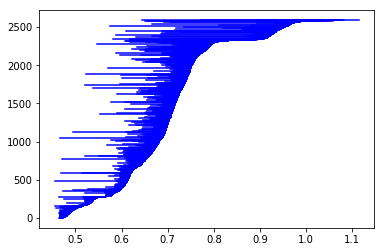

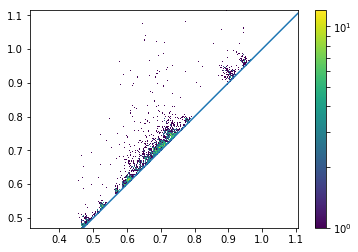

In [13]:
vectors = transorm(vectors_1)
        
f_lower_star = dn.fill_freudenthal(vectors)
p = dn.homology_persistence(f_lower_star)
dgms = dn.init_diagrams(p, f_lower_star)
dn.plot.plot_bars(dgms[1], show = True, order='death')
dn.plot.plot_diagram_density(dgms[1], show = True)

In [ ]:
tsne_plot(model_1)

### Plots for Woskresenie

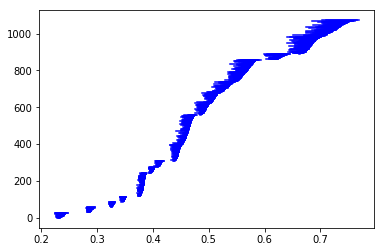

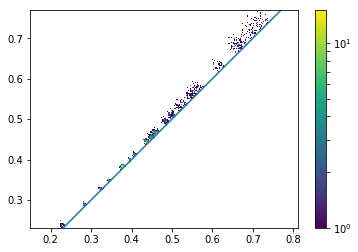

In [12]:
vectors = transorm(vectors_2)
        
f_lower_star = dn.fill_freudenthal(vectors)
p = dn.homology_persistence(f_lower_star)
dgms = dn.init_diagrams(p, f_lower_star)
dn.plot.plot_bars(dgms[1], show = True, order='death')
dn.plot.plot_diagram_density(dgms[1], show = True)

In [ ]:
tsne_plot(model_2)

In [ ]:
dn.plot.plot_bars(dgms[1], show = True, order='death')

## Gogol part

In [14]:
dgms_3, model_3, vectors_3 = analyze_text('/Users/alexey/Documents/GitHub/dialog_persistent/texts/shinel')
dgms_4, model_4, vectors_4 = analyze_text('/Users/alexey/Documents/GitHub/dialog_persistent/texts/vii')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
vectors = transorm(vectors_3)

f_lower_star = dn.fill_freudenthal(vectors)
p = dn.homology_persistence(f_lower_star)
dgms = dn.init_diagrams(p, f_lower_star)
dn.plot.plot_bars(dgms[0], show = True, order='death')

In [ ]:
vectors = transorm(vectors_4)

f_lower_star = dn.fill_freudenthal(vectors)
p = dn.homology_persistence(f_lower_star)
dgms = dn.init_diagrams(p, f_lower_star)
dn.plot.plot_bars(dgms[0], show = True, order='death')

In [ ]:
dn.wasserstein_distance(dgms_3[0], dgms_4[0])

In [ ]:
dn.wasserstein_distance(dgms_1[0], dgms_4[0])

In [ ]:
dn.wasserstein_distance(dgms_2[0], dgms_4[0])

In [ ]:
dn.wasserstein_distance(dgms_2[0], dgms_3[0])

In [ ]:
dn.wasserstein_distance(dgms_1[0], dgms_3[0])

## Nabokov part

In [26]:
dgms_5, model_5, vectors_5 = analyze_text('/Users/alexey/Documents/GitHub/dialog_persistent/texts/mashenka.txt')
dgms_6, model_6, vectors_6 = analyze_text('/Users/alexey/Documents/GitHub/dialog_persistent/texts/dar.txt', min_count=20)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [36]:
print(dn.wasserstein_distance(dgms_5[1], dgms_6[1]))

print(len(vectors_6), len(vectors_5))

3.6027541160583496
522 508


Воскресение и Машенька

In [28]:
dn.wasserstein_distance(dgms_2[1], dgms_5[1])

5.49077844619751

In [31]:
dn.wasserstein_distance(dgms_1[1], dgms_6[1])

3.892972707748413

In [32]:
dn.wasserstein_distance(dgms_2[1], dgms_6[1])

4.166779518127441

In [33]:
dn.wasserstein_distance(dgms_1[1], dgms_2[1])

1.0947972536087036

Анна Каренина и Дар

In [34]:
dn.wasserstein_distance(dgms_1[1], dgms_6[1])

3.892972707748413

In [35]:
dn.wasserstein_distance(dgms_1[1], dgms_5[1])

5.047041893005371

In [ ]:
vectors = transorm(vectors_5)

f_lower_star = dn.fill_freudenthal(vectors)
p = dn.homology_persistence(f_lower_star)
dgms = dn.init_diagrams(p, f_lower_star)
dn.plot.plot_bars(dgms[0], show = True, order='death')

In [ ]:
vectors = transorm(vectors_6)

f_lower_star = dn.fill_freudenthal(vectors)
p = dn.homology_persistence(f_lower_star)
dgms = dn.init_diagrams(p, f_lower_star)
dn.plot.plot_bars(dgms[0], show = True, order='death')

In [ ]:
dn.wasserstein_distance(dgms_5[0], dgms_6[0])

In [ ]:
print(len(vectors_5), len(vectors_6))